## **Getting started**

**Business Objective:**

“Will a customer accept the coupon?” The goal of this project is to use what you know about visualizations and probability distributions to distinguish between customers who accepted a driving coupon versus those who did not.

**Problem Statement:** Determine which features are most strongly associated with coupon acceptance and provide actionable insights.


**Proposed Process Resolution:**
This notebook analyzes the factors influencing coupon acceptance (Y=1) versus non-acceptance (Y=0):
Coupon Acceptance/Rejection Fetures Discovery/Analysis/Correlation. Including data clensing, correlation analysis, and visualizations that compares key features.


**Findings:**
  **Age** and certain time thresholds (e.g., **toCoupon_GEQ15min** and **toCoupon_GEQ25min**) are strong predictors of coupon acceptance.
  **Some features, like **temperature**, are more related to coupon rejection.



In [5]:
# Import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno
import datetime as dt

import os
from google.colab import files


# for UCB 5.1 Coupan db cleanup, exploration, analysis, feature engineering

# Data Cleaning & Preparation

## Steps:
### 1. Remove rows with missing values in key columns.
### 2. Drop duplicate rows.
### 3. Convert specific columns to numeric.
### 4. Split the dataset into coupon accepted (Y=1) and not accepted (Y=0).
### 5. Cap outliers at the 1st and 99th percentiles.
### 6. Measure strongest correlation
### 7. Check Violin charts to confirm

#  Correlation Analysis
## Coupon Acceptance Analysis

## The top three features correlated with coupon acceptance are:
### - **age**
### - **occupation_Legal**
### - **car_crossover**


# least correlated: direction_same

# Recommendation:
## Target by Age as it is  most correlated with coupon acceptance.


In [9]:
#file list
files = os.listdir('/content/')
print(files)

['.config', 'sample_data']


In [67]:
# upload data csv files, uncomment
from google.colab import files
uploaded = files.upload()

Saving coupons.csv to coupons (1).csv


In [87]:
#load uploaded csv file
cpn = pd.read_csv('/content/coupons.csv')
# print(cpn.count())

In [88]:
# Explore data
# cpn.head()
# cpn.describe()
# cpn.info()
# cpn.isna().sum()



In [89]:
# Lower Case Col Names
cpn.columns = cpn.columns.str.lower()
cpn.columns

key_columns = ['destination', 'passanger', 'weather', 'temperature', 'time', 'coupon',
       'expiration', 'gender', 'age', 'maritalstatus', 'has_children',
       'education', 'occupation', 'income', 'car', 'bar', 'coffeehouse',
       'carryaway', 'restaurantlessthan20', 'restaurant20to50',
       'tocoupon_geq5min', 'tocoupon_geq15min', 'tocoupon_geq25min',
       'direction_same', 'direction_opp', 'y']

In [90]:
# loop for all col unuques
for colname in key_columns:
  print(colname)
  print( cpn[colname].unique() )

destination
['No Urgent Place' 'Home' 'Work']
passanger
['Alone' 'Friend(s)' 'Kid(s)' 'Partner']
weather
['Sunny' 'Rainy' 'Snowy']
temperature
[55 80 30]
time
['2PM' '10AM' '6PM' '7AM' '10PM']
coupon
['Restaurant(<20)' 'Coffee House' 'Carry out & Take away' 'Bar'
 'Restaurant(20-50)']
expiration
['1d' '2h']
gender
['Female' 'Male']
age
['21' '46' '26' '31' '41' '50plus' '36' 'below21']
maritalstatus
['Unmarried partner' 'Single' 'Married partner' 'Divorced' 'Widowed']
has_children
[1 0]
education
['Some college - no degree' 'Bachelors degree' 'Associates degree'
 'High School Graduate' 'Graduate degree (Masters or Doctorate)'
 'Some High School']
occupation
['Unemployed' 'Architecture & Engineering' 'Student'
 'Education&Training&Library' 'Healthcare Support'
 'Healthcare Practitioners & Technical' 'Sales & Related' 'Management'
 'Arts Design Entertainment Sports & Media' 'Computer & Mathematical'
 'Life Physical Social Science' 'Personal Care & Service'
 'Community & Social Services' 

In [91]:
# drop nulls, blanks..., dedup, reset index
# cpn = cpn.dropna(how="any").reset_index(drop=True)


cpnduplicates = cpn.duplicated(subset = key_columns, keep = False)
print( "cpnduplicates count" )
print( cpnduplicates.count() )

cpn = cpn.dropna(subset=key_columns).drop_duplicates().reset_index(drop=True).copy()
# confirm nulls, blanks.. removed
# cpn.isna().sum()
print( "cpn count" )
print( cpn.count() )

cpnduplicates count
12684
cpn count
destination             108
passanger               108
weather                 108
temperature             108
time                    108
coupon                  108
expiration              108
gender                  108
age                     108
maritalstatus           108
has_children            108
education               108
occupation              108
income                  108
car                     108
bar                     108
coffeehouse             108
carryaway               108
restaurantlessthan20    108
restaurant20to50        108
tocoupon_geq5min        108
tocoupon_geq15min       108
tocoupon_geq25min       108
direction_same          108
direction_opp           108
y                       108
dtype: int64


In [92]:
# strip dollar sign from income

cpn['income'] = cpn['income'].str.replace("$", "", regex=False)


In [93]:

# One-hot encode categorical columns
categorical_cols = [
    "destination", "passanger", "weather", "coupon", "expiration",
    "gender", "maritalstatus", "education", "occupation", "car"
]
cpn = pd.get_dummies(cpn, columns=categorical_cols, drop_first=True)


In [101]:
# Cleanse: Data transformation to numeric where possible
# Convert Age to integer
cpn["age"] = cpn["age"].astype(int)

# Convert Income to numerical (midpoints of the range)
income_map = {
    "$12500 - $24999": 18750,
    "$37500 - $49999": 43750,
    "$87500 - $99999": 93750,
    "$100000 or More": 100000
}
cpn["income"] = cpn["income"].map(income_map)

# Convert ordinal categorical values to numerical
ordinal_mapping = {
    "never": 0,
    "less1": 0.5,
    "1~3": 2,
    "4~8": 6,
    "gt8": 9
}
cpn["bar"] = cpn["bar"].map(ordinal_mapping)
cpn["coffeehouse"] = cpn["coffeehouse"].map(ordinal_mapping)
cpn["carryaway"] = cpn["carryaway"].map(ordinal_mapping)
cpn["restaurantlessthan20"] = cpn["restaurantlessthan20"].map(ordinal_mapping)
cpn["restaurant20to50"] = cpn["restaurant20to50"].map(ordinal_mapping)


# Convert time to 24-hour format
time_map = {
    "7AM": 7, "10AM": 10, "2PM": 14, "6PM": 18, "10PM": 22
}
cpn["time"] = cpn["time"].map(time_map)


binary_cols = [
    "has_children", "tocoupon_geq5min", "tocoupon_geq15min",
    "tocoupon_geq25min", "direction_same", "direction_opp", "y"
]

cpn[binary_cols] = cpn[binary_cols].astype(int)

cpn = cpn.dropna().reset_index(drop=True)


In [106]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# cpn[["temperature", "income"]] = scaler.fit_transform(cpn[["temperature", "income"]])


In [107]:
# split datasets for yes/no coupons


# Split data based on coupon acceptance or not
cpnYes = cpn[cpn['y'] == 1].copy()
cpnNo  = cpn[cpn['y'] == 0].copy()

print("cpn yes count")
# print( cpnYes.count() ) # 62, > 32 for statistical sample needed
print("------------------------------------------")

print("cpn no count")
# print( cpnNo.count() ) # 46, > 32 for statistical sample needed
print("------------------------------------------")
# cpn.dtypes

cpn yes count
------------------------------------------
cpn no count
------------------------------------------


In [138]:

# OUTLIERS Quantile CLEANUP for yes and no coupon dataset split
## Cap outliers for each numeric column in both groups (1st to 99th percentiles) 'gender',
numeric_cols = ['income', 'age',  'temperature', 'time',  'time',
'bar', 'coffeehouse', 'carryaway', 'restaurantlessthan20', 'restaurant20to50', "has_children", "tocoupon_geq5min", "tocoupon_geq15min",
"tocoupon_geq25min", "direction_same", "direction_opp", "y"]


for col in numeric_cols:
  lower_cap_yes = cpn[col].quantile(0.01)
  upper_cap_yes = cpn[col].quantile(0.99)
  cpn[col] = cpn[col].clip(lower_cap_yes, upper_cap_yes)

  lower_cap_yes = cpnYes[col].quantile(0.01)
  upper_cap_yes = cpnYes[col].quantile(0.99)
  cpnYes[col] = cpnYes[col].clip(lower_cap_yes, upper_cap_yes)

  lower_cap_no = cpnNo[col].quantile(0.01)
  upper_cap_no = cpnNo[col].quantile(0.99)
  cpnNo[col] = cpnNo[col].clip(lower_cap_no, upper_cap_no)

#save clean data file
cpn.to_csv('1_coupon_csv-clean-accept-yes.csv', index=False)
cpnYes.to_csv('2_coupon_csv-clean-accept-yes.csv', index=False)
cpnNo.to_csv('3_coupon_csv-clean-accept-no.csv', index=False)


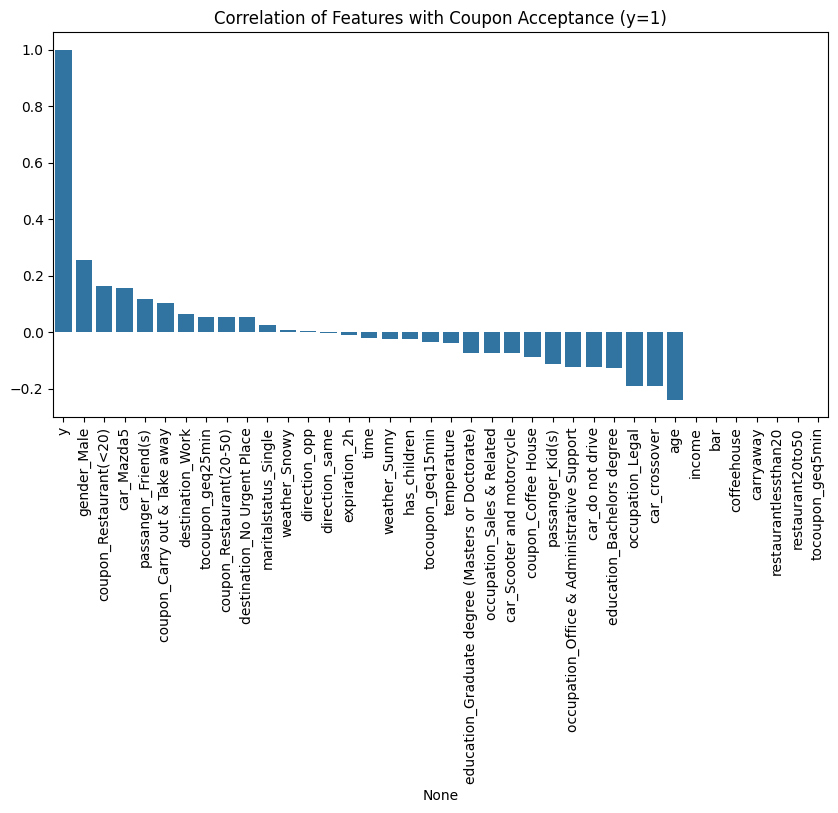

------------------------------------------
Overall Correlation with Y=1 Acceptance
y                                                   1.000000
gender_Male                                         0.255724
coupon_Restaurant(<20)                              0.161962
car_Mazda5                                          0.156699
passanger_Friend(s)                                 0.117765
coupon_Carry out & Take away                        0.102911
destination_Work                                    0.064866
tocoupon_geq25min                                   0.053682
coupon_Restaurant(20-50)                            0.053682
destination_No Urgent Place                         0.053296
maritalstatus_Single                                0.026210
weather_Snowy                                       0.006620
direction_opp                                       0.002065
direction_same                                     -0.002065
expiration_2h                                      -0.010419
ti

In [143]:

#  CORRELATION ANALYSIS
#  Coupon Acceptance Analysis


# Corr matrix numeric: ID features strongly associated with coupon acceptance.
# Features with high positive correlation are more prevalent in the coupon accepted group.


# Compute overall correlation matrix


# Compute correlation with y
corr_matrix = cpn.corr()
correlation_with_y = corr_matrix["y"].sort_values(ascending=False)

# Visualizing correlation
plt.figure(figsize=(10, 5))
sns.barplot(x=correlation_with_y.index, y=correlation_with_y.values)
plt.xticks(rotation=90)
plt.title("Correlation of Features with Coupon Acceptance (y=1)")

#  Save the figure before displaying
plot_filename = "4_correlation_coupon_acceptance.png"
plt.savefig(plot_filename, bbox_inches='tight')

# Show the plot after saving
plt.show()


print("------------------------------------------")

print("Overall Correlation with Y=1 Acceptance")
print(corr_matrix['y'].sort_values(ascending=False))
print("------------------------------------------")
# Identify top features by absolute correlation with Y (excluding Y itself)
corr_features = corr_matrix['y'].drop('y').abs().sort_values(ascending=False)
print("\nFeatures sorted by absolute correlation with Y:")
print(corr_features)
print("------------------------------------------")
nocorr_features = corr_matrix['y'].drop('y').abs().sort_values(ascending=True)
print("\nFeatures sorted by Least correlation with Y:")
print(nocorr_features)
print("------------------------------------------")
# %% [markdown]


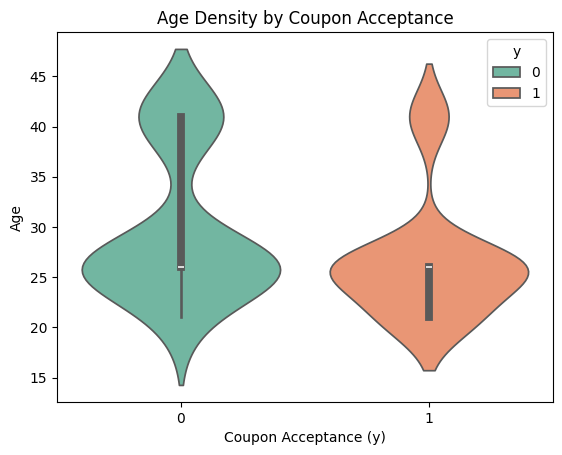


Features sorted by correlation with y=1 Coupon Acceptance (ascending):
age                                                -0.239270
occupation_Legal                                   -0.191880
car_crossover                                      -0.191880
education_Bachelors degree                         -0.126799
car_do not drive                                   -0.122260
occupation_Office & Administrative Support         -0.122260
passanger_Kid(s)                                   -0.112546
coupon_Coffee House                                -0.088412
car_Scooter and motorcycle                         -0.075767
occupation_Sales & Related                         -0.075767
education_Graduate degree (Masters or Doctorate)   -0.075767
temperature                                        -0.039738
tocoupon_geq15min                                  -0.034143
has_children                                       -0.026210
weather_Sunny                                      -0.024995
time         

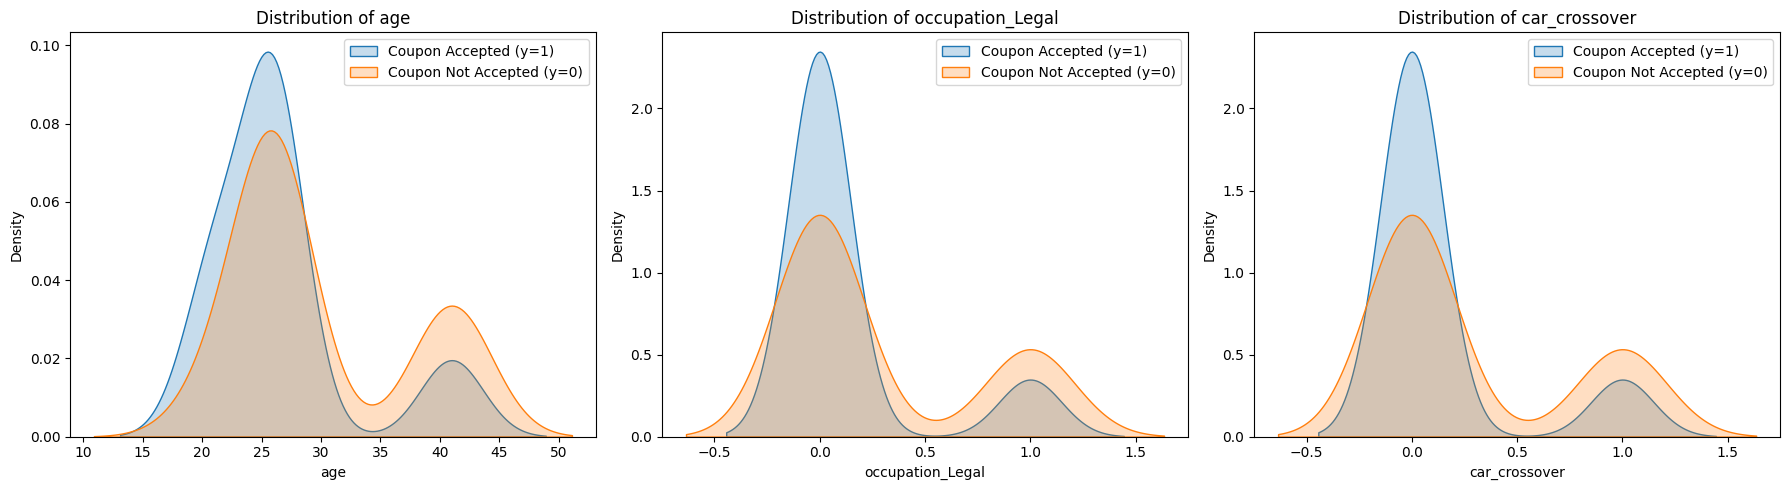

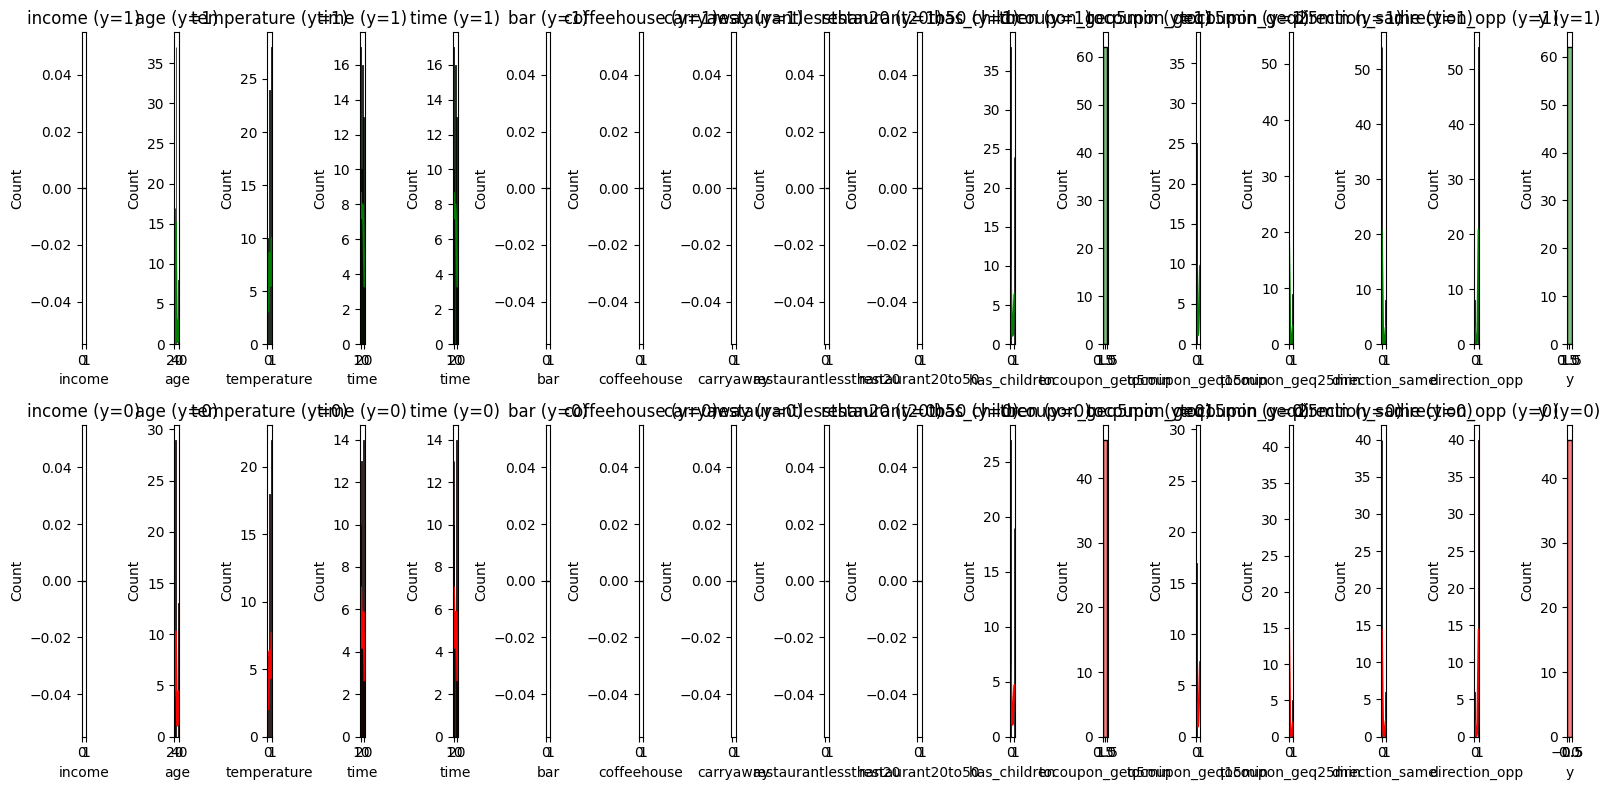

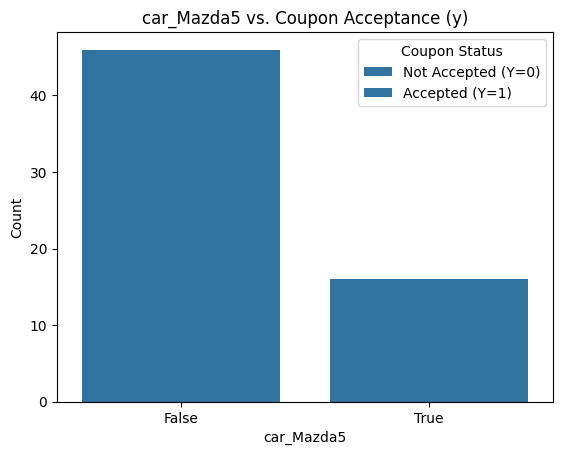

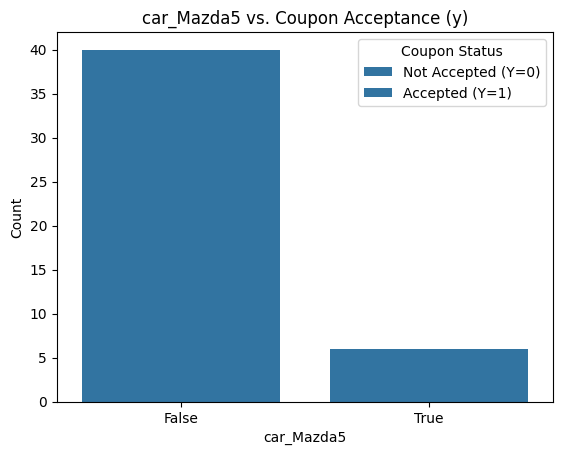

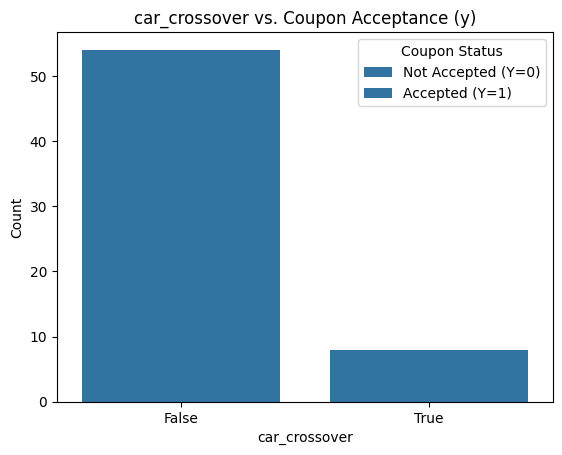

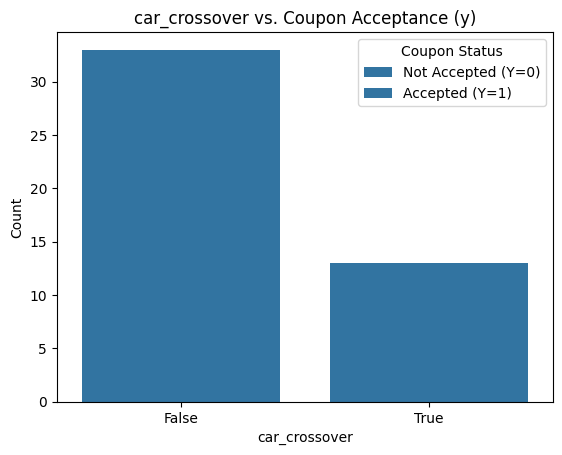

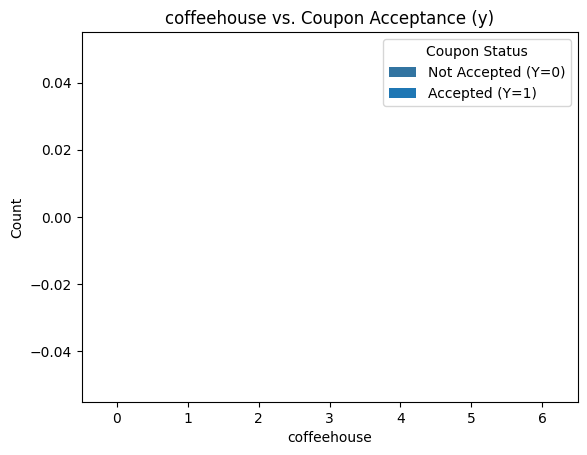

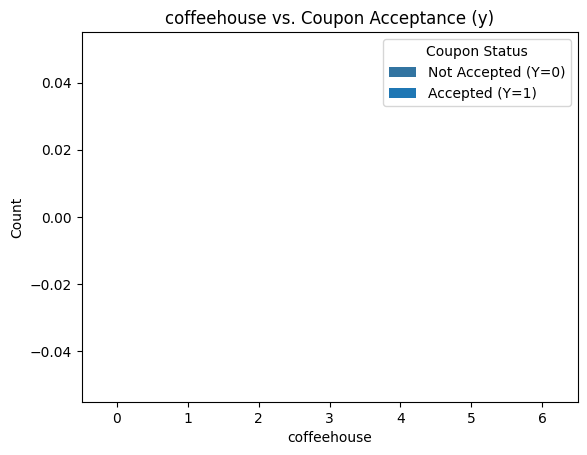

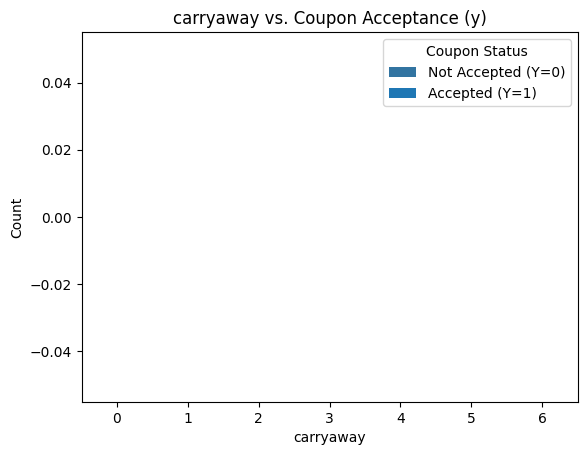

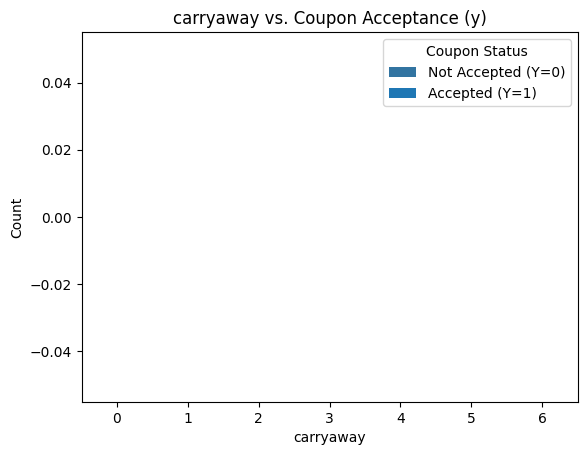

In [135]:

# Supporting Charts: KDE, Violin, Bar
# see: KDE & Violin Plots of distribution for these features ( both coupon acceptance/rejection ).

# %% [PLOTS Seaborn  kdeplot]
features_to_plot = ['gender_Male', 'age', 'car_crossover', 'occupation_Legal', 'oupon_Restaurant(<20)', 'car_Mazda5', 'education_Bachelors degree ']

# plt.figure(figsize=(18, 5))
#for i, feature in enumerate(features_to_plot):
    # plt.subplot(1, 3, i+1)
    # sns.kdeplot(data=cpnYes, x=feature, label='Coupon Accepted (Y=1)', fill=True)
    # sns.kdeplot(data=cpnNo,  x=feature, label='Coupon Not Accepted (Y=0)', fill=True)
    # plt.title(f"Distribution of {feature}")
    # plt.xlabel(feature)
    # plt.ylabel('Density')
    # plt.legend()
# plt.tight_layout()
# plt.savefig("./4_top3_features_accepting_coupon.png")  # Save plot
# plt.show()
#


# Violin plot confirms age correlation to coupon
sns.violinplot(x='y', y='age', data=cpn, hue='y', palette='Set2', legend=True)
plt.title("Age Density by Coupon Acceptance")
plt.xlabel("Coupon Acceptance (y)")
plt.ylabel("Age")
plt.show()

# Violin plot confirms toCoupon_GEQ15min correlation to coupon
# sns.violinplot(x='y', y='toCoupon_GEQ15min', data=cpnYes, hue='y', palette='Set2', legend=True)
# plt.title("toCoupon_GEQ15min Density by Coupon Acceptance")
# plt.xlabel("Coupon Acceptance (Y)")
# plt.ylabel("toCoupon_GEQ15min")
# plt.show()
# Violin plot confirms toCoupon_GEQ25min correlation to coupon
# sns.violinplot(x='Y', y='toCoupon_GEQ25min', data=cpnYes, hue='y', palette='Set2', legend=True)
# plt.title("toCoupon_GEQ25min Density by Coupon Acceptance")
# plt.xlabel("Coupon Acceptance (Y)")
# plt.ylabel("toCoupon_GEQ25min")
# plt.show()

# Violin plot  Temp inverse correlation to coupon
# sns.violinplot(x='Y', y='temperature', data=cpnYes, hue='Y', palette='Set2', legend=True)
# plt.title("temperature Density by Coupon Acceptance")
# plt.xlabel("Coupon Acceptance (Y)")
# plt.ylabel("temperature")
# plt.show()


# Violin plot  Temp inverse correlation to coupon
# sns.violinplot(x='Y', y='direction_same', data=cpnYes, hue='Y', palette='Set2', legend=True)
# plt.title("Direction_same Density by Coupon Acceptance")
# plt.xlabel("Coupon Acceptance (Y)")
# plt.ylabel("direction_same")
# plt.show()


#DBL check corr matrix# Compute the correlation matrix

# yescorr_matrix = cpnYes.corr()

# Assume 'Y' is your coupon acceptance column (with 1 indicating acceptance)
# Get correlations of all features with Y, excluding Y itself
# target_corr = yescorr_matrix['Y'].drop('Y')

# Find the feature with the highest absolute correlation with Y
# most_corr_feature = target_corr.abs().idxmax()
# yescorrelation_value = target_corr[most_corr_feature]
# yescorrelation_value


#nocorr_matrix = cpnNo.corr()
# Assume 'Y' is your coupon rejection column (with 0 indicating rejection)
# Get correlations of all features with Y, excluding Y itself
# target_corr = nocorr_matrix['Y'].drop('Y')

# Find the feature with the highest absolute correlation with Y
# most_corr_feature = target_corr.abs().idxmax()
# nocorrelation_value = target_corr[most_corr_feature]
# nocorrelation_value

# %% [markdown]
# ## Coupon Non-Acceptance Analysis
#
# Features with negative correlations (i.e., more associated with coupon non-acceptance).
#  visualize top three features associated with coupon rejection.

# %% [code]
negative_corr_features = corr_matrix['y'].drop('y').sort_values()
print("\nFeatures sorted by correlation with y=1 Coupon Acceptance (ascending):")
print(negative_corr_features)

top3_not_accept = negative_corr_features.head(3)
print("\nTop 3 features most correlated with coupon not accepted (Y=0):")
print(top3_not_accept)

features_to_plot_not_accept = top3_not_accept.index.tolist()

plt.figure(figsize=(18, 5))
for i, feature in enumerate(features_to_plot_not_accept):
    plt.subplot(1, 3, i+1)
    sns.kdeplot(data=cpnYes, x=feature, label='Coupon Accepted (y=1)', fill=True)
    sns.kdeplot(data=cpnNo,  x=feature, label='Coupon Not Accepted (y=0)', fill=True)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout()
plt.savefig("./5_top3_features_not_accepting_coupon.png")  # Save plot
plt.show()

# %% [markdown]
# ## Additional Feature Exploration
#
# Histograms are plotted for each numeric feature for both coupon accepted and non-accepted groups.
# This helps to further understand the distribution differences.

# %% [code]
fig, axes = plt.subplots(nrows=2, ncols=len(numeric_cols), figsize=(16, 8))
for i, col in enumerate(numeric_cols):
    sns.histplot(cpnYes[col], ax=axes[0, i], kde=True, color='green')
    axes[0, i].set_title(f"{col} (y=1)")
    sns.histplot(cpnNo[col], ax=axes[1, i], kde=True, color='red')
    axes[1, i].set_title(f"{col} (y=0)")
plt.tight_layout()
plt.show()

# %% [markdown]
# ## Categorical Variable Analysis
#
# explore categorical variables and their relation to coupon acceptance using count plots.


# %% [code]
cat_cols = ['car_Mazda5', 'car_crossover',    'coffeehouse', 'carryaway',]
for col in cat_cols:

    sns.countplot(x=col, hue='y', data=cpnYes)
    plt.title(f"{col} vs. Coupon Acceptance (y)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend(title='Coupon Status', labels=['Not Accepted (Y=0)', 'Accepted (Y=1)'])
    plt.show()


    sns.countplot(x=col, hue='y', data=cpnNo)
    plt.title(f"{col} vs. Coupon Acceptance (y)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend(title='Coupon Status', labels=['Not Accepted (Y=0)', 'Accepted (Y=1)'])
    plt.show()



